C:\Users\swift\PycharmProjects\Spoofing\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 Using device: cuda
📥 Loading ResNet models...
📥 Setting up MediaPipe...
📥 Loading MiDaS depth model...


C:\Users\swift\PycharmProjects\Spoofing\.venv\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


📥 Loading trained model...
✅ Loaded model expecting 4426 features
🧪 Starting inference...


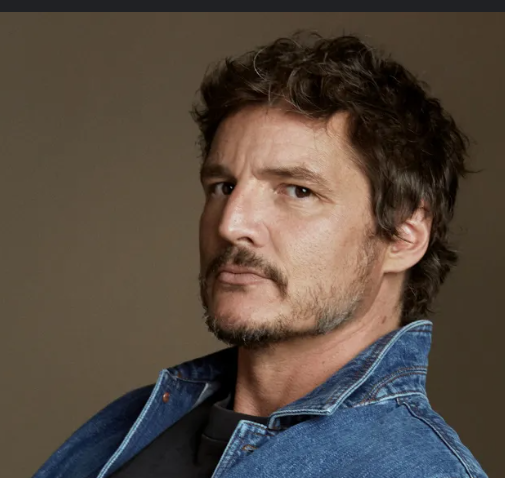

✅ real-test6.png: REAL (Real:99.8% | Fake:0.2%)


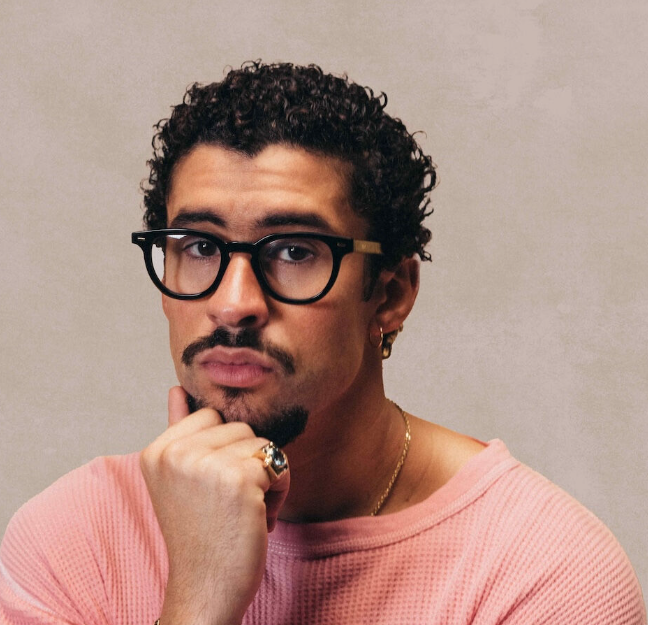

✅ real-test8.png: REAL (Real:88.9% | Fake:11.1%)


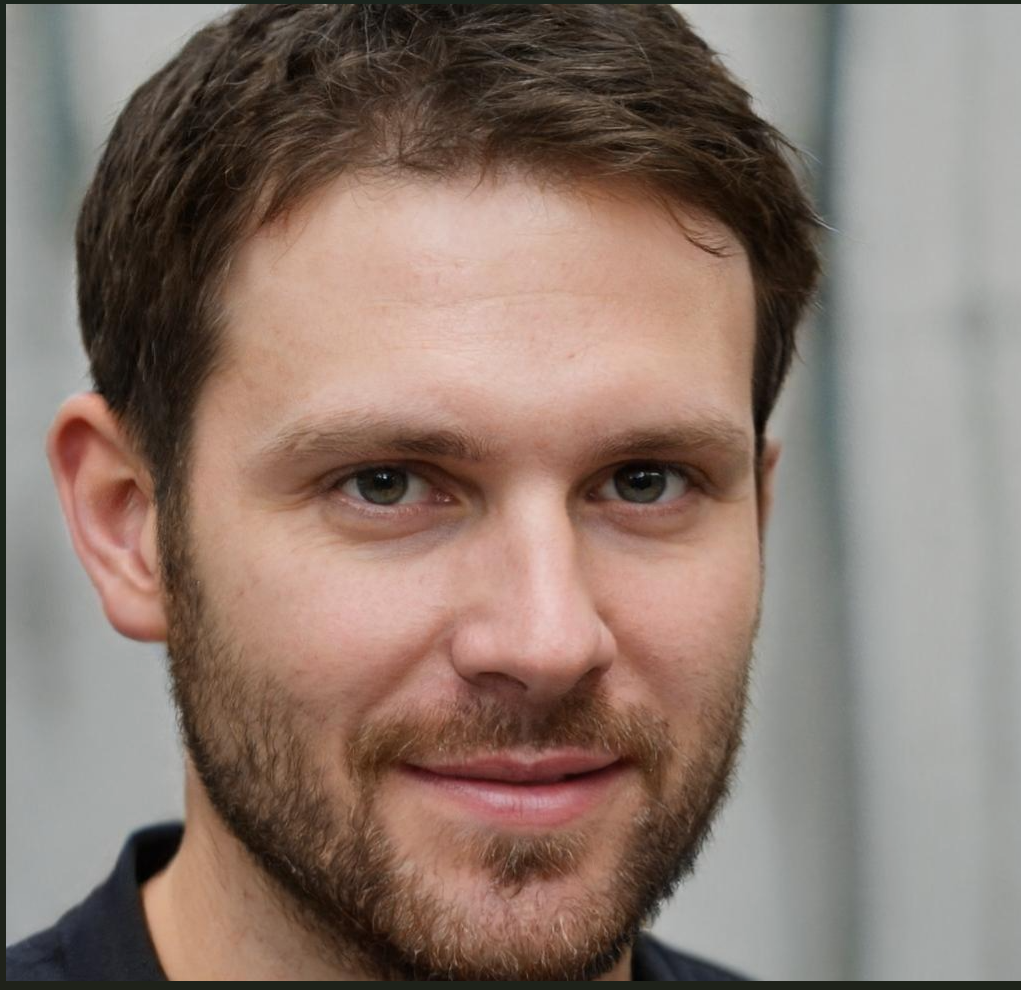

✅ extrafake2.png: FAKE (Real:3.2% | Fake:96.8%)


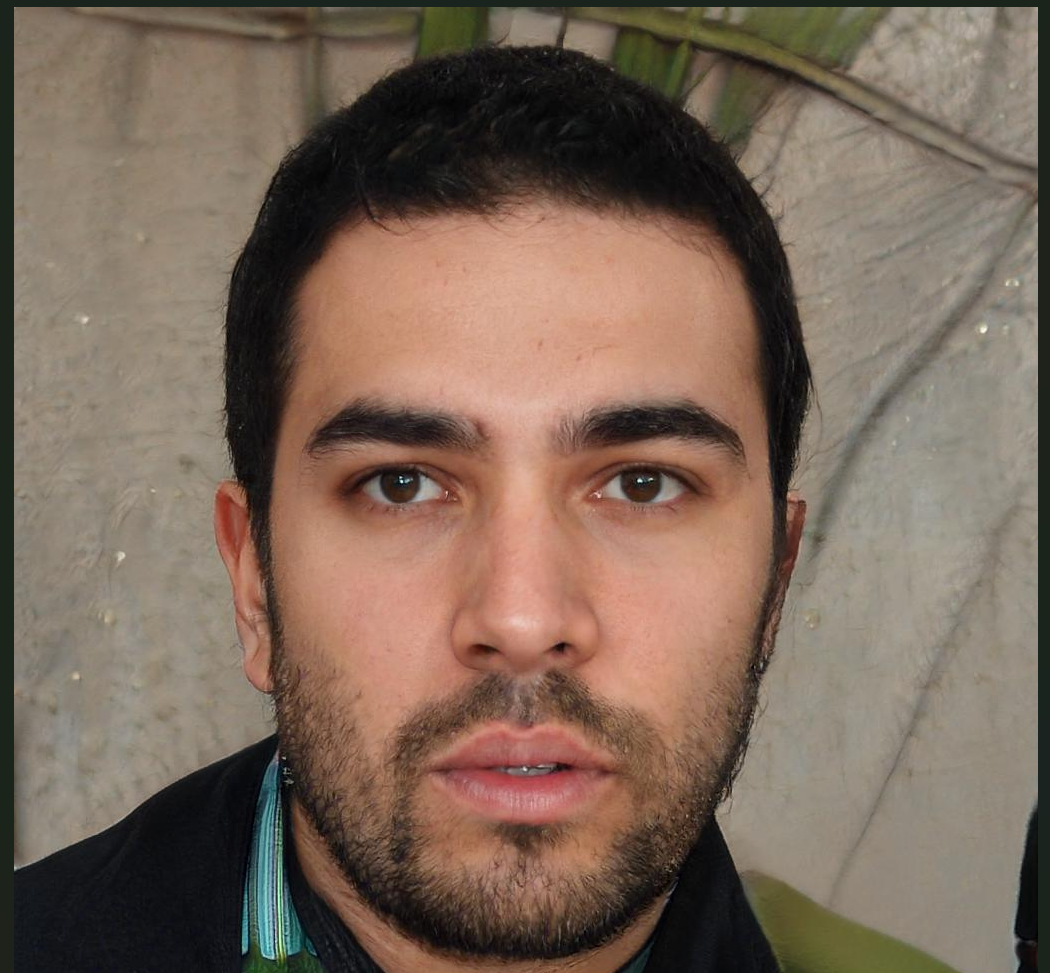

✅ extrafake3.png: FAKE (Real:27.2% | Fake:72.8%)

📋 Summary:
   REAL (Real: 99.8% | Fake:  0.2%) - real-test6.png
   REAL (Real: 88.9% | Fake: 11.1%) - real-test8.png
   FAKE (Real:  3.2% | Fake: 96.8%) - extrafake2.png
   FAKE (Real: 27.2% | Fake: 72.8%) - extrafake3.png
🎉 Inference complete!


In [1]:
# === COMPLETE MINIMAL INFERENCE SCRIPT ===
# This is everything you need to run inference only

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image as PILImage
import mediapipe as mp
from transformers import DPTForDepthEstimation
import torch.nn as nn
import warnings
import os

# Suppress warnings and force load
warnings.filterwarnings("ignore", category=UserWarning)
os.environ['TORCH_FORCE_WEIGHTS_ONLY_LOAD'] = '0'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using device: {device}")


# === MODEL ARCHITECTURE (REQUIRED) ===
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


# === MODELS SETUP ===
def load_resnet():
    base = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    return torch.nn.Sequential(
        *list(base.children())[:-2],
        torch.nn.AdaptiveAvgPool2d((1, 1)),
        torch.nn.Flatten()
    ).eval().to(device)


print("📥 Loading ResNet models...")
resnet_texture = load_resnet()
resnet_patch = load_resnet()

resnet_tf = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

depth_tf = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# MediaPipe setup
print("📥 Setting up MediaPipe...")
mp_face = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

FACIAL_PATCHES = {
    "left_eye": list(range(33, 42)) + list(range(160, 165)),
    "right_eye": list(range(263, 272)) + list(range(385, 390)),
    "nose": [1, 2, 5, 6, 19, 20, 98, 99, 327, 328],
    "mouth": list(range(61, 68)) + list(range(291, 298)) + [13, 14, 17, 18],
    "left_cheek": [116, 117, 118, 119, 120, 121, 126, 142],
    "right_cheek": [345, 346, 347, 348, 349, 350, 355, 371],
    "forehead": [9, 10, 151, 337, 299, 333, 298, 301]
}


# === FEATURE EXTRACTION FUNCTIONS ===
def extract_texture_feature_cnn(image_rgb):
    """Texture analysis"""
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    sobel_features = []
    for ksize in [3, 5]:
        sobelx = cv2.Sobel(enhanced, cv2.CV_64F, 1, 0, ksize=ksize)
        sobely = cv2.Sobel(enhanced, cv2.CV_64F, 0, 1, ksize=ksize)
        sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
        sobel_features.append(sobel)

    combined_sobel = np.mean(sobel_features, axis=0)
    sobel_normalized = np.uint8(np.clip(combined_sobel, 0, 255))
    sobel_rgb = np.stack([sobel_normalized] * 3, axis=-1)

    img_tensor = resnet_tf(sobel_rgb).unsqueeze(0).to(device)
    with torch.no_grad():
        features = resnet_texture(img_tensor).squeeze()

    return features


def crop_patch(image_rgb, landmarks, indices):
    """Crop face patches"""
    h, w, _ = image_rgb.shape
    points = np.array([(int(landmarks[i].x * w), int(landmarks[i].y * h)) for i in indices])

    if len(points) == 0:
        return None

    x, y, pw, ph = cv2.boundingRect(points)

    padding = 5
    x = max(0, x - padding)
    y = max(0, y - padding)
    pw = min(w - x, pw + 2 * padding)
    ph = min(h - y, ph + 2 * padding)

    if pw < 15 or ph < 15:
        return None

    patch = image_rgb[y:y + ph, x:x + pw]
    return patch


def extract_patch_feature_aligned(image_rgb):
    """Patch analysis"""
    results = mp_face.process(image_rgb)
    if not results.multi_face_landmarks:
        return torch.zeros(len(FACIAL_PATCHES) * 512).to(device)

    feats = []
    landmarks = results.multi_face_landmarks[0].landmark

    for region_name, region_indices in FACIAL_PATCHES.items():
        patch = crop_patch(image_rgb, landmarks, region_indices)
        if patch is None:
            feats.append(torch.zeros(512).to(device))
        else:
            patch_resized = cv2.resize(patch, (64, 64))
            img_tensor = resnet_tf(patch_resized).unsqueeze(0).to(device)
            with torch.no_grad():
                patch_feat = resnet_patch(img_tensor).squeeze()
                feats.append(patch_feat)

    return torch.cat(feats, dim=0)


def extract_depth_feature(image_rgb, midas_model):
    """Depth analysis"""
    pil_image = PILImage.fromarray(image_rgb)
    from PIL import ImageFilter
    blurred = pil_image.filter(ImageFilter.BLUR)

    midas_input = depth_tf(blurred).unsqueeze(0).to(device)
    with torch.no_grad():
        depth_map = midas_model(pixel_values=midas_input).predicted_depth.squeeze()

    depth_min, depth_max = depth_map.min(), depth_map.max()
    if depth_max - depth_min > 1e-8:
        norm = (depth_map - depth_min) / (depth_max - depth_min)
    else:
        norm = torch.zeros_like(depth_map)

    depth_features = []
    for size in [(8, 8), (16, 16)]:
        pooled = F.adaptive_avg_pool2d(norm.unsqueeze(0).unsqueeze(0), size)
        depth_features.append(pooled.flatten())

    return torch.cat(depth_features, dim=0)


def extract_boundary_features(image_rgb):
    """Boundary analysis"""
    results = mp_face.process(image_rgb)
    if not results.multi_face_landmarks:
        return np.zeros(10)

    landmarks = results.multi_face_landmarks[0].landmark
    h, w, _ = image_rgb.shape

    face_contour_indices = [
        10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288,
        397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136,
        172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109
    ]

    boundary_points = []
    for idx in face_contour_indices:
        x = int(landmarks[idx].x * w)
        y = int(landmarks[idx].y * h)
        boundary_points.append((x, y))

    boundary_points = np.array(boundary_points)

    mask = np.zeros((h, w), dtype=np.uint8)
    cv2.fillPoly(mask, [boundary_points], 255)

    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(mask, kernel, iterations=3)
    eroded_mask = cv2.erode(mask, kernel, iterations=3)
    boundary_region = dilated_mask - eroded_mask

    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    boundary_edges = edges * (boundary_region > 0)
    edge_density = np.sum(boundary_edges > 0) / np.sum(boundary_region > 0) if np.sum(
        boundary_region > 0) > 0 else 0

    gradient_features = []
    for channel in range(3):
        channel_data = image_rgb[:, :, channel]
        grad_x = cv2.Sobel(channel_data, cv2.CV_64F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(channel_data, cv2.CV_64F, 0, 1, ksize=3)
        gradient_mag = np.sqrt(grad_x ** 2 + grad_y ** 2)
        boundary_gradient = gradient_mag * (boundary_region > 0)
        avg_boundary_grad = np.mean(boundary_gradient[boundary_gradient > 0]) if np.any(
            boundary_gradient > 0) else 0
        gradient_features.append(avg_boundary_grad)

    return np.array(
        [edge_density] + gradient_features + [0, 0, 0, 0, 0, 0])  # Simplified to 10 features


def extract_combined_features(image_rgb, midas_model):
    """Combined feature extraction"""
    tex = extract_texture_feature_cnn(image_rgb)
    patch = extract_patch_feature_aligned(image_rgb)
    depth = extract_depth_feature(image_rgb, midas_model)
    boundary = extract_boundary_features(image_rgb)

    tex_norm = F.normalize(tex.flatten(), dim=0)
    patch_norm = F.normalize(patch.flatten(), dim=0)
    depth_norm = F.normalize(depth.flatten(), dim=0)
    boundary_norm = F.normalize(torch.tensor(boundary, dtype=torch.float32).to(device), dim=0)

    combined = torch.cat([
        0.35 * tex_norm,
        0.40 * patch_norm,
        0.15 * boundary_norm,
        0.10 * depth_norm
    ], dim=0)

    return combined.detach().cpu().numpy()


# === LOAD MIDAS ===
print("📥 Loading MiDaS depth model...")
midas = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to(device).eval()


# === MODEL LOADING ===
def load_trained_model(model_path='improved_deepfake_detector.pth'):
    """Fixed loading with environment override"""
    try:
        checkpoint = torch.load(model_path, map_location=device, weights_only=False)
    except TypeError:
        checkpoint = torch.load(model_path, map_location=device)

    model = ImprovedMLP(checkpoint['feature_dim']).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    scaler = checkpoint['scaler']

    print(f"✅ Loaded model expecting {checkpoint['feature_dim']} features")
    return model, scaler


# === TESTING FUNCTION ===
def test_multiple_images(image_paths, model, scaler, midas_model):
    """Test multiple images and show summary"""
    results = []

    for path in image_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                print(f"❌ Could not load {path}")
                continue

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Show image
            from PIL import Image
            from IPython.display import display
            img_pil = Image.open(path)
            display(img_pil)

            # Extract features
            features = extract_combined_features(img_rgb, midas_model)
            features = features.reshape(1, -1)

            # Scale features
            features_scaled = scaler.transform(features)

            # Convert to tensor
            features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(device)

            # Make prediction
            with torch.no_grad():
                logit = model(features_tensor).squeeze()
                probability = float(logit.cpu().numpy())
                prediction = "FAKE" if probability > 0.5 else "REAL"

            real_prob = (1 - probability) * 100
            fake_prob = probability * 100

            results.append({
                'path': path,
                'prediction': prediction,
                'real_prob': real_prob,
                'fake_prob': fake_prob
            })

            print(f"✅ {path}: {prediction} (Real:{real_prob:.1f}% | Fake:{fake_prob:.1f}%)")

        except Exception as e:
            print(f"❌ Error processing {path}: {e}")
            continue

    print("\n📋 Summary:")
    for r in results:
        print(
            f"   {r['prediction']:4s} (Real:{r['real_prob']:5.1f}% | Fake:{r['fake_prob']:5.1f}%) - {r['path']}")


# === MAIN EXECUTION ===
if __name__ == "__main__":
    print("📥 Loading trained model...")
    model, scaler = load_trained_model('improved_deepfake_detector.pth')

    test_images = [
        "real-test6.png",
        "real-test8.png",
        "extrafake2.png",
        "extrafake3.png"
        # Add more images here
    ]

    print("🧪 Starting inference...")
    test_multiple_images(test_images, model, scaler, midas)
    print("🎉 Inference complete!")